In [57]:
import requests
from bs4 import BeautifulSoup
import glob
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import KFold
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Data Collection

In this step I gathered all the urls for the articles and and wrote the main text body of each article to a new text document. I also wrote the categories and article titles to seprate text files which are both stored in seperate folders. 

In [2]:
base_url = 'http://mlg.ucd.ie/modules/COMP41680/archive/'

In [3]:
# open hmtl connection
response = requests.get(base_url + "index.html")
# parse the html page
soup = BeautifulSoup(response.content, "html.parser")

In [4]:
# store links in list 
links = []
#get all links on the page
all_links = soup.find_all("a")
#append links to list
for link in all_links:
    links.append(link.get("href"))
# remove end of list which is whitespace
links = links[0:12]

# Open a file to store all the catagories and titles
catfile = open('docs/cat/categories.txt', 'w')
titlefile = open('docs/title/titles.txt', 'w')

count = 0
# Iterate through and each page, parsing each one with bs
for link in links:
    response = requests.get(base_url + link)
    soup1 = BeautifulSoup(response.content, "html.parser")
    # get table with class: categroy
    categories = soup1.findAll('td', {"class":"category"})
    # write all catagories to a file 
    for cat in categories:
        catfile.write("%s\n" % cat.find(text=True))
    # get article titles
    for link in soup1.findAll("a")[:-4]:
        title = link.string
        titlefile.write("%s\n" % title)
    # get all links to the paragraph pages    
    all_doc_links = soup1.find_all("a", attrs={'href': re.compile("^art")})
    for l in all_doc_links:
        doc_url = l.get("href")
        response_doc = requests.get(base_url + doc_url)
        soup2 = BeautifulSoup(response_doc.content, "html.parser")
        # Write all paragraphs to seperate files
        paragraphs = soup2.find_all("p")
#         docfile = open('docs/' + doc_url + '.txt', 'w', encoding="utf-8")
        docfile = open('docs/doc_'+ str(count) + '.txt', 'w', encoding="utf-8")
        count +=1
        for par in paragraphs:
            docfile.write("%s\n" % par.text.strip())
        docfile.close()    
catfile.close()



## Load Data

In this step I got the name of every text file in the documents folder and read each file, storing the contents in a tuple with the documents corresponding title and category. All tuples were then saved to a list which is the corpus. 

I had to remove the N/A from the categories list as there we're some empty links on the webpage so the categories and documents did not match correctly. After removing the N/A they now match. 

In [3]:
# load files and their corrosponding classes
path = 'docs'
cat_path = 'docs/cat/categories.txt'
title_path = 'docs/title/titles.txt'
corpus_list = []
# get all filenames of the docs
file_list = sorted(glob.glob(os.path.join(path, '*.txt')), key=os.path.getmtime)
# read and save all the categories to a list and the same with titles
category_list = [line.strip() for line in open(cat_path, 'r').readlines()]
titles_list = [line.strip() for line in open(title_path, 'r').readlines()]
# Due to some links being remoeved, I will have to remove the N/A from the catergory list so the catergories and documents matchup
while "N/A" in category_list: category_list.remove("N/A")  
# Each elemnt in the corpus list is a tuple with the class label and the document contents
for cat, title, file_path in zip(category_list, titles_list, file_list):
    text = ""
    for line in open(file_path, 'r', encoding="utf8").readlines():
        text += line.strip()
    tup = (cat, title, text)
    corpus_list.append(tup)


I wrote the code below to manually pre-process the text but I noticed that the performance of the pre-processing was not as accurate as when using the sckit learn Tfidf-vectoriser with stemming as I have implemented below.

In [6]:
# # Preprocess 
# lemmatizer = WordNetLemmatizer()
# stopword_list = stopwords.words()
# processed_corpus_list = []

# for doc in corpus_list:
#     token_list = nltk.word_tokenize(doc[2])
#     processed_tokens = []
#     for token in token_list:
#         lower = token.lower()
#         if len(token) > 2 and token not in stopword_list:
#             lemma = lemmatizer.lemmatize(token)
#             processed_tokens.append(lemma)
#     document = (doc[0], doc[1] ,processed_tokens)
#     processed_corpus_list.append(document)
            

In [4]:
# Create a dataframe
df = pd.DataFrame(corpus_list, columns= ["category","title", "documents"])
df.head()


,category,title,documents
0,technology,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...
1,business,Asian quake hits European shares,Asian quake hits European sharesShares in Euro...
2,technology,BT offers free net phone calls,BT is offering customers free internet telepho...
3,business,Barclays shares up on merger talk,Barclays shares up on merger talkShares in UK ...
4,sport,Barkley fit for match in Ireland,England centre Olly Barkley has been passed fi...


In [5]:
# check for null values
df.isnull().sum()

category     0
title        0
documents    0
dtype: int64

## Pre-Process and create TF-IDF matrix 

I tested pre-processing the text using the method above and the method below. I found the method below seemed to process the text better. The StemmedTFIDFVectorizer failed to remove some punctuation and digits so I removed them manually before. I also removed words that were less then 3 characters. I found a way of implementing the TFIDFVectorizer with stemming incorporated from stack overflow. 

In [20]:
# The bleow StemmedTFIDFVectorizer struggles to remove digits and puctuation so
# I will remove these first. Also removing words shorter then 2
df['documents'] = df['documents'].str.replace('\d+', '') # for digits
df['documents'] = df['documents'].str.replace(r'(\b\w{1,2}\b)', '') # for words
df['documents'] = df['documents'].str.replace('[^\w\s]', '') # for punctuation 

# Documents and Target 
X = df['documents']
y = df['category']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Taken from https://stackoverflow.com/questions/26195699/sklearn-how-to-speed-up-a-vectorizer-eg-tfidfvectorizer

english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTFIDFVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTFIDFVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

# Create the vectoriser object
vectorizer_s = StemmedTFIDFVectorizer(strip_accents = 'unicode',min_df=5,\
                                      ngram_range=(1,2), analyzer="word",\
                                      stop_words='english')

# Create the weighted document-term matrixes with pre-processing applied. 
train_X = vectorizer_s.fit_transform(X_train)
# Convert to dataframes so they can be viewed 
X_train_df = pd.DataFrame(train_X.toarray(), columns=vectorizer_s.get_feature_names())
test_X = vectorizer_s.transform(X_test)
X_test_df = pd.DataFrame(test_X.toarray(), columns=vectorizer_s.get_feature_names())




## Text Classification

The models I decided to use were: K-Nearest Neigbhour and Multinomal Navie Bayes. I performed a hold out evaluation and also performed cross validation. 


In [10]:
# Dict to hold classifers performance 
model_valid_accuracy_comparisons = {}

In [11]:
# Multinomal Navie Bayes 
# Create the Classifer and fit the train and target data
mnb = MultinomialNB()
mnb.fit(train_X, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

We can see that the model performed very well with an accuracy score of 98.7%. The model mis-classified technology 2 times and business 2 times. It only mis-classified sport once. 

In [12]:
# Make a set of predictions
y_pred = mnb.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_valid_accuracy_comparisons["Naive Bayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.987593052109
             precision    recall  f1-score   support

   business       0.99      0.99      0.99       150
      sport       0.99      1.00      1.00       144
 technology       0.98      0.97      0.98       109

avg / total       0.99      0.99      0.99       403

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,148,0,2,150
sport,0,144,0,144
technology,2,1,106,109
All,150,145,108,403


In [13]:
# Create the Classifer and fit the train and target data

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

K-Nearest Neighbours also performed very well with a accuracy score of 96.5%. It mis-classified technology 8 times and sport 1 times while mistaking business 5 times. It seems that the model struggled most with differentiating between technology and business.  

In [14]:
# K-Nearest Neigbhour 
# Make a set of predictions
y_pred = knn.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_valid_accuracy_comparisons["knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.965260545906
             precision    recall  f1-score   support

   business       0.97      0.95      0.96       150
      sport       0.99      0.97      0.98       144
 technology       0.93      0.98      0.96       109

avg / total       0.97      0.97      0.97       403

Confusion Matrix


Predicted,business,sport,technology,All
True,,,,
business,143,1,6,150
sport,3,139,2,144
technology,2,0,107,109
All,148,140,115,403


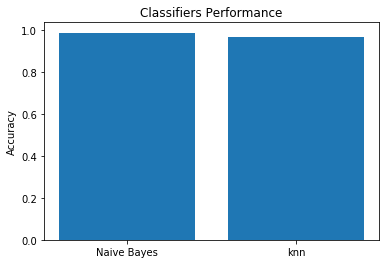

In [15]:
# Plot performance of Classifiers 
plt.bar(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
plt.xticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))
plt.ylabel("Accuracy")
plt.title("Classifiers Performance")
plt.show()

#### Cross-Validation

In [30]:
# Perform crossvalidation 

#list to store scores at each fold
knn_acc_list = []
mnb_acc_list = []
# store confusion matrixes
knn_confusion_list = []
mnb_confusion_list = []

# K = 10 
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Create the weighted document-term matrixes with pre-processing applied. 
    CV_X_train = vectorizer_s.fit_transform(X_train)
    CV_X_test = vectorizer_s.transform(X_test)
    
    #MNB
    mnb = MultinomialNB()
    mnb.fit(CV_X_train, y_train)
    y_pred_mnb = mnb.predict(CV_X_test)
    #KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(CV_X_train, y_train)
    y_pred_knn = knn.predict(CV_X_test)
    
    # Store scores
    accuracy_mnb = metrics.accuracy_score(y_test, y_pred_mnb)
    mnb_acc_list.append(accuracy_mnb)
    accuracy_knn = metrics.accuracy_score(y_test, y_pred_knn) 
    knn_acc_list.append(accuracy_knn)
    # Store confusion matrixs
    cnf_matrix_mnb = confusion_matrix(y_test, y_pred_mnb)
    cnf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
    knn_confusion_list.append(cnf_matrix_knn)
    
    mnb_confusion_list.append(cnf_matrix_mnb)

In [53]:
knn_mean_acc = np.mean(knn_acc_list,axis=0) 
mnb_mean_acc = np.mean(mnb_acc_list,axis=0) 

# Sum up evrey confusion matrix and store as a DF
final_knn = np.zeros((3,3))
final_mnb = np.zeros((3,3))
for i, x in enumerate(mnb_confusion_list):
    
    final_mnb = final_mnb + mnb_confusion_list[i]
    final_knn = final_knn + knn_confusion_list[i]    

col = ['business', 'sport' ,'technology']
knn_confusion_df = pd.DataFrame(final_knn, columns=col, index=col)
mnb_confusion_df = pd.DataFrame(final_mnb, columns=col, index=col)

In [77]:
print("MNB accuracy score:", mnb_mean_acc )
mnb_confusion_df

MNB accuracy score: 0.980327868852


,business,sport,technology
business,420.0,1.0,9.0
sport,4.0,454.0,0.0
technology,6.0,4.0,322.0


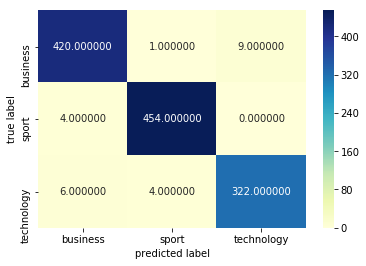

In [76]:
ax = sns.heatmap(mnb_confusion_df, annot=True, fmt='f', cmap="YlGnBu")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()

MultinomialNB performed very well with a accuracy score of 98.0%. It mis-classified technology 10 times and sport 5 times while mistaking business 10 times. It seems that the model struggled most with differentiating between technology and business.

In [55]:
print("KNN accuracy score:", knn_mean_acc )
knn_confusion_df

KNN accuracy score: 0.959836065574


,business,sport,technology
business,402.0,11.0,17.0
sport,6.0,450.0,2.0
technology,9.0,4.0,319.0


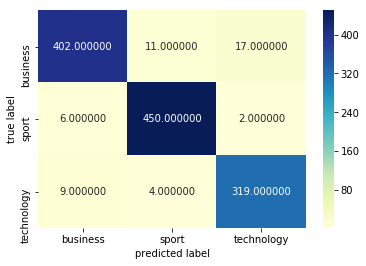

In [78]:
ax = sns.heatmap(knn_confusion_df, annot=True, fmt='f', cmap="YlGnBu")
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.show()

3-Nearest Neighbours performed very well with a accuracy score of 95.9%. It mis-classified technology 13 times and sport 8 times while mistaking business 28 times. It seems that the model struggled most trying to predict business. This is where KNN fall down compared to MNB.

### Conclusion

Comparing both models we can see that both performed very well at classifying the documents. The Naive Bayes model outperformed the K-NN model by 2% in accuracy. It also received a higher F1-score of 0.99 compared to 0.97.

Overall it seemed that both models struggled differentiating between technology and business with KNN struggling more then MNB here but results are highly satisfactory. 